In [1]:
import wandb, argparse, torch, json
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
    EarlyStopping,
    ModelCheckpoint,
)

from bondnet.data.dataset import ReactionNetworkDatasetPrecomputed
from bondnet.data.dataloader import DataLoaderPrecomputedReactionGraphs
from bondnet.data.dataset import train_validation_test_split
from bondnet.utils import seed_torch
from bondnet.model.training_utils import (
    get_grapher,
    LogParameters,
    load_model_lightning,
)

seed_torch()
torch.set_float32_matmul_precision("high")  # might have to disable on older GPUs

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# check cuda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1. model config

In [3]:
config = {'augment': True,
 'batch_size': 4,
 'debug': False,
 'classifier': False,
 'classif_categories': 3,
 'cat_weights': [1.0, 1.0, 1.0],
 'embedding_size': 24,
 'epochs': 100,
 'extra_features': ['bond_length'],
 'extra_info': [],
 'filter_species': [3, 5],
 'fc_activation': 'ReLU',
 'fc_batch_norm': True,
 'fc_dropout': 0.2,
 'fc_hidden_size_1': 256,
 'fc_hidden_size_shape': 'flat',
 'fc_num_layers': 1,
 'gated_activation': 'ReLU',
 'gated_batch_norm': False,
 'gated_dropout': 0.1,
 'gated_graph_norm': False,
 'gated_hidden_size_1': 512,
 'gated_hidden_size_shape': 'flat',
 'gated_num_fc_layers': 1,
 'gated_num_layers': 2,
 'gated_residual': True,
 'learning_rate': 0.003,
 'precision': 32,
 'loss': 'mse',
 'num_lstm_iters': 3,
 'num_lstm_layers': 1,
 'on_gpu': True,
 'restore': False,
 'target_var': 'dG_sp',
 'target_var_transfer': 'diff',
 'weight_decay': 0.0,
 'max_epochs': 100,
 'max_epochs_transfer': 100,
 'transfer': False,
 'filter_outliers': True}

dataset_loc = "/pscratch/sd/w/wenxu/jobs/CRNs/data/reduceQ9.json"

on_gpu = config["on_gpu"]
extra_keys = config["extra_features"]
debug = config["debug"]
precision = config["precision"]

if precision == "16" or precision == "32":
    precision = int(precision)

if on_gpu:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

extra_keys = config["extra_features"]

# 2. load json and processing it into Reaction networks graphs in cpu

In [4]:
dataset = ReactionNetworkDatasetPrecomputed(
    grapher=get_grapher(extra_keys),
    file=dataset_loc,
    target=config["target_var"],
    classifier=config["classifier"],
    classif_categories=config["classif_categories"],
    filter_species=config["filter_species"],
    filter_outliers=config["filter_outliers"],
    filter_sparse_rxns=False,
    debug=debug,
    device="cpu",
    extra_keys=extra_keys,
    extra_info=config["extra_info"],
)

reading file from: /pscratch/sd/w/wenxu/jobs/CRNs/data/reduceQ9.json
rxn raw len: 100
Program finished in 0.6527696939883754 seconds
.............failures.............
reactions len: 96
valid ind len: 96
bond break fail count: 		0
default fail count: 		4
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 96
features: 288
labels: 96
molecules: 288
constructing graphs & features....
number of graphs valid: 288
number of graphs: 288
prebuilding reaction graphs


# 3. Write Reaction networks graphs to lmdb files in parallel

In [5]:
import sys 
sys.path.insert(0, sys.path[0]+"/../")
from tmp.lmdb_dataset import LmdbDataset, CRNs2lmdb

In [6]:
config = {
    "out_path": "/pscratch/sd/w/wenxu/jobs/CRNs/lmdb_data",  # Update the directory path
    "num_workers": 3,
    "output_file": "merged_data.lmdb"
}
CRNs2lmdb(dataset, config)

Worker 0: Writing CRNs Objects into LMDBs: 100%|██████████| 32/32 [00:00<00:00, 222.95it/s]

Worker 1: Writing CRNs Objects into LMDBs: 100%|██████████| 32/32 [00:00<00:00, 240.85it/s]


Worker 2: Writing CRNs Objects into LMDBs: 100%|██████████| 32/32 [00:00<00:00, 361.80it/s]


Deleted file: /pscratch/sd/w/wenxu/jobs/CRNs/lmdb_data/_tmp_data.0000.lmdb-lock
Deleted file: /pscratch/sd/w/wenxu/jobs/CRNs/lmdb_data/_tmp_data.0001.lmdb
Deleted file: /pscratch/sd/w/wenxu/jobs/CRNs/lmdb_data/_tmp_data.0002.lmdb
Deleted file: /pscratch/sd/w/wenxu/jobs/CRNs/lmdb_data/_tmp_data.0000.lmdb
Deleted file: /pscratch/sd/w/wenxu/jobs/CRNs/lmdb_data/_tmp_data.0001.lmdb-lock
Deleted file: /pscratch/sd/w/wenxu/jobs/CRNs/lmdb_data/_tmp_data.0002.lmdb-lock


# 4. Load lmdb files 

In [7]:
_lmdb = LmdbDataset({"src" : "/pscratch/sd/w/wenxu/jobs/CRNs/lmdb_data/merged_data.lmdb"})

In [8]:
print(_lmdb.num_samples, _lmdb.dtype, _lmdb.feature_size, _lmdb.feature_name)

96 float32 {'atom': 20, 'bond': 8, 'global': 7} {'atom': ['total degree', 'is in ring', 'total H', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'chemical symbol', 'ring size', 'ring size', 'ring size', 'ring size', 'ring size'], 'bond': ['metal bond', 'ring inclusion', 'ring size', 'ring size', 'ring size', 'ring size', 'ring size', 'bond_length'], 'global': ['num atoms', 'num bonds', 'molecule weight', 'charge one hot', 'charge one hot', 'charge one hot', 'charge one hot']}


# 5. Train BondNet

In [9]:
config = json.load(open("/pscratch/sd/w/wenxu/jobs/CRNs/bondnet-santi_dev/bondnet/scripts/training/settings.json", "r"))
log_save_dir = "./logs_lightning/"
dict_for_model = {
    "extra_features": extra_keys,
    "classifier": config["classifier"],
    "classif_categories": config["classif_categories"],
    "filter_species": config["filter_species"],
    "filter_outliers": config["filter_outliers"],
    "filter_sparse_rxns": False,
    "debug": debug,
    "in_feats": dataset.feature_size,
}
config["batch_size"] = 24

config.update(dict_for_model)
#! 2. split dataset.  train_validation_test_split is in bondnet dataset.
trainset, valset, testset = train_validation_test_split(
    dataset, validation=0.15, test=0.15
)

print(">" * 40 + "config_settings" + "<" * 40)
for k, v in config.items():
    print("{}\t\t\t{}".format(str(k).ljust(20), str(v).ljust(20)))

print(">" * 40 + "config_settings" + "<" * 40)

#! 3. dataloader
val_loader = DataLoaderPrecomputedReactionGraphs(
    valset, batch_size=len(valset), shuffle=False
)
test_loader = DataLoaderPrecomputedReactionGraphs(
    testset, batch_size=len(testset), shuffle=False
)
train_loader = DataLoaderPrecomputedReactionGraphs(
    trainset, batch_size=config["batch_size"], shuffle=True
)

model = load_model_lightning(config, device=device, load_dir=log_save_dir)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>config_settings<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
augment             			True                
batch_size          			24                  
debug               			False               
classifier          			False               
classif_categories  			3                   
cat_weights         			[1.0, 1.0, 1.0]     
embedding_size      			24                  
epochs              			100                 
extra_features      			['bond_length']     
extra_info          			[]                  
filter_species      			[3, 5]              
fc_activation       			ReLU                
fc_batch_norm       			True                
fc_dropout          			0.2                 
fc_hidden_size_1    			256                 
fc_hidden_size_shape			flat                
fc_num_layers       			1                   
gated_activation    			ReLU                
gated_batch_norm    			False               
gated_dropout       			0.1                 
gated_graph_norm    			F

/global/homes/w/wenxu/.conda/envs/CRNs/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/global/homes/w/wenxu/.conda/envs/CRNs/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /pscratch/sd/w/wenxu/jobs/CRNs/notebook/logs_lightning exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name          | Type                | Params
-------------------------------------------------------
0  | embedding     | UnifySize           | 840   
1  | 

Sanity Checking: 0it [00:00, ?it/s]

/global/homes/w/wenxu/.conda/envs/CRNs/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/global/homes/w/wenxu/.conda/envs/CRNs/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/global/homes/w/wenxu/.conda/envs/CRNs/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (3

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00052: reducing learning rate of group 0 to 1.2000e-03.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/global/homes/w/wenxu/.conda/envs/CRNs/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_l1             0.467753142118454
        test_loss           0.4864932596683502
         test_r2            0.09335166215896606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▁▁▁
test_l1,▁
test_loss,▁
test_r2,▁
train_l1,▅█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▄█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▆▇▇▇▇▇▇▇▇█▇███████████████████████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_l1,█▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


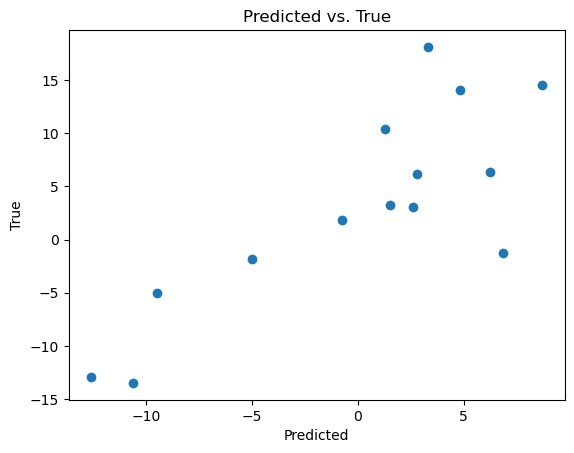

In [10]:
project_name = "test"
with wandb.init(project=project_name
               ) as run:
    log_parameters = LogParameters()
    logger_tb = TensorBoardLogger(log_save_dir, name="test_logs")
    logger_wb = WandbLogger(project=project_name, name="test_logs")
    lr_monitor = LearningRateMonitor(logging_interval="step")

    checkpoint_callback = ModelCheckpoint(
        dirpath=log_save_dir,
        filename="model_lightning_{epoch:02d}-{val_loss:.2f}",
        monitor="val_loss",  # TODO
        mode="min",
        auto_insert_metric_name=True,
        save_last=True,
    )
    early_stopping_callback = EarlyStopping(
        monitor="val_loss", min_delta=0.00, patience=500, verbose=False, mode="min"
    )

    trainer = pl.Trainer(
        max_epochs=config["max_epochs"],
        accelerator="gpu",
        devices=[0],
        accumulate_grad_batches=5,
        enable_progress_bar=True,
        gradient_clip_val=1.0,
        callbacks=[
            early_stopping_callback,
            lr_monitor,
            log_parameters,
            checkpoint_callback,
        ],
        enable_checkpointing=True,
        default_root_dir=log_save_dir,
        logger=[logger_tb, logger_wb],
        precision=precision,
    )

    trainer.fit(model, train_loader, val_loader)
    trainer.test(model, test_loader)

run.finish()